In [1]:
!git clone https://github.com/dh5473/k_youth.git

Cloning into 'k_youth'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 150 (delta 25), reused 66 (delta 9), pack-reused 56
Receiving objects: 100% (150/150), 110.37 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [32]:
%cd k_youth

/content/k_youth


In [ ]:
# 필요한 모듈 불러오기

from PIL import Image
from torchvision import models
from torch.autograd import Function
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch
import datetime
import shutil
import cv2
import os

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

kyouth_model = models.resnet50(pretrained=False).to(device)

# For Initializing & prediction
kyouth_model.fc = nn.Sequential(
               nn.Linear(2048, 2),
               ).to(device)

kyouth_model.load_state_dict(torch.load('./model_checkpoint/CAM_onlyapple_state.pth'))

for param in kyouth_model.parameters():
    param.requires_grad = True

# For GuidedBackPropReLU

gb_kyouth_model = models.resnet50(pretrained=False).to(device)

gb_kyouth_model.fc = nn.Sequential(
               nn.Linear(2048, 2),
               ).to(device)

gb_kyouth_model.load_state_dict(torch.load('./model_checkpoint/CAM_onlyapple_state.pth'))

for param in gb_kyouth_model.parameters():
    param.requires_grad = True

In [6]:
class GuidedBackpropReLU(Function): 
    @staticmethod # 인스턴스를 생성하지 않아도 활용 가능
    def forward(self, input_img): # 순전파에서 ReLU output이 0 이상인 값 구하기
        # 마스크 생성
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output) # save_for_backward : forward 함수 내에서만 사용가능하며, tensor를 저장해줌.
        return output

    @staticmethod
    def backward(self, grad_output): # 역전파에서 Guided Backpropagation 구해주기
        
        # forward에서 저장된 saved tensor를 불러오기
        input_img, output = self.saved_tensors
        grad_input = None

        # input image 기준으로 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_1 = (input_img > 0).type_as(grad_output)
        
        # 모델의 결과가 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        
        # 먼저 모델의 결과와 positive_mask_1과 곱해주고,
        # 다음으로는 positive_mask_2와 곱해줘서 
        # 모델의 결과가 양수이면서 input image가 양수인 부분만 남도록 만들어줌
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input

In [7]:
class GuidedBackpropReLUModel(torch.nn.Module):
    def __init__(self, model, use_cuda):
        super().__init__()
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # ReLU 모듈을 새로 재정의한 GuidedBackPropReLU로 대체해준다.
        recursive_relu_apply(self.model) # .apply는 torch.autograd.Function의 속성 중 하나

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None): # __call__ : 인스턴스가 호출되었을 때 실행된다
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True) # 텐서 연산 정보 저장

        output = self.forward(input_img) # 순전파

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy()) # output은 순전파 과정에서 0 이상인 부분만 반환한다.

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1 # 0 이상인 부분에 1만 오는 one_hot 인코딩 진행
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output) # one_hot * output을 활용하여 마스킹된 정보 얻음
        # 모델이 예측한 결과값을 기준으로 backward 진행
        one_hot.backward(retain_graph=True)

        # input image의 gradient를 저장
        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))
        return output # np array 배열로 저장된 output

In [8]:
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1) # np.clip : min보다 작은 값은 min으로, max 값보다 큰 값은 max 값으로 바꿔줌 -> np.clip(array, min, max)
    return np.uint8(img * 255)

In [9]:
# final conv layer name 
finalconv_name = 'layer4'

# activations
feature_blobs = []

# gradients
backward_feature = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data)

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])

# hook을 걸어줘서 layer를 지날 때 어떤 값이 나오는지 확인 가능하다.
kyouth_model._modules.get(finalconv_name).register_forward_hook(hook_feature)
kyouth_model._modules.get(finalconv_name).register_full_backward_hook(backward_hook)

In [10]:
gb_kyouth_model.train()

gb_model = GuidedBackpropReLUModel(model=gb_kyouth_model, use_cuda=True)

In [39]:
def img_preprocess(img_path):
  img = Image.open(img_path)

  normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      normalize
  ])

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  img_tensor = preprocess(img)
  img_tensor = img_tensor.unsqueeze(0).to(device)

  return img_tensor  


def classification(model, img_path):
  model.eval()
  # final conv layer name 
  finalconv_name = 'layer4'

  # activations, gradients
  feature_blobs = []
  backward_feature = []

  # output으로 나오는 feature를 feature_blobs에 append하도록
  def hook_feature(module, input, output):
      feature_blobs.append(output.cpu().data)

  # Grad-CAM
  def backward_hook(module, input, output):
      backward_feature.append(output[0])

  # hook을 걸어줘서 layer를 지날 때 어떤 값이 나오는지 확인 가능하다.
  kyouth_model._modules.get(finalconv_name).register_forward_hook(hook_feature)
  kyouth_model._modules.get(finalconv_name).register_full_backward_hook(backward_hook)

  # img_path에 들어온 이미지 처리
  img = img_preprocess(img_path)
 
  # softmax weight
  params = list(model.parameters())
  weight_softmax = np.squeeze(params[-2].cpu().detach().numpy())

  # 예측
  logit = model(img)
  
  # 확률값, 클래스 반환
  result = F.softmax(logit, dim=1).data.squeeze()
  probs, idx = result.sort(0, True) 
  
  prob = probs[0].item() * 100 
  predicted_class_idx = idx[0].item()  

  return prob, predicted_class_idx, logit, img, feature_blobs, backward_feature

def gradCAM(model, guided_relu_model, img_path):
  _, _, logit, img, feature_blobs, backward_feature = classification(model, img_path)

  ''' Grad CAM '''
  score = logit[:, 0].squeeze() # 예측값 y^c
  score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

  activations = feature_blobs[0].to(device) # (1, 512, 7, 7), forward activations
  
  # gradient 구한 뒤 GAP해주기
  gradients = backward_feature[0] # (1, 512, 7, 7), backward gradients
  b, k, u, v = gradients.size()
  alpha = torch.mean(gradients.view(b, k, -1), dim = 2) # Global Average Pooling
  weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1) -> 차원 맞춰주기


  grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
  grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
  grad_cam_map = F.interpolate(grad_cam_map, size=(224, 224), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
  
  # grad-CAM 정규화
  map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
  grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling

  # heatmap 결과(grad-CAM)
  grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy
  grad_result = grad_heatmap + np.array(img.cpu().squeeze(0).permute(1,2,0))
  grad_result = grad_result / np.max(grad_result)
  grad_result = np.uint8(255 * grad_result) 

  # Guided Backpropagation 결과
  gb_num = guided_relu_model(img, target_category = 0)
  gb = deprocess_image(gb_num) # (224, 224, 3), numpy

  # Guided grad-CAM
  grayscale_cam = grad_cam_map.squeeze(0).cpu().numpy() # (1, 224, 224), numpy
  grayscale_cam = grayscale_cam[0, :] # (224, 224)
  cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam]) # (224, 224, 3)
  cam_gb = deprocess_image(cam_mask * gb_num) 

  ''' 파일 저장 '''
  # 시간
  current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
  current_time = current_time.strftime('%Y-%m-%d-%H:%M')

  # 파일 경로 설정
  resnet50_saved_loc = './results' + '/' + current_time 
  if os.path.exists(resnet50_saved_loc):
    shutil.rmtree(resnet50_saved_loc)
  os.makedirs(resnet50_saved_loc)

  # 파일 저장
  cv2.imwrite(os.path.join(resnet50_saved_loc + '/', "Heat_Map.jpg"), grad_result)
  cv2.imwrite(os.path.join(resnet50_saved_loc + '/', "gb.jpg"), gb)
  cv2.imwrite(os.path.join(resnet50_saved_loc + '/', "Guided_Grad_CAM.jpg"), cam_gb)

  # 파일 저장 경로 반환
  grad_heatmap_path =  os.path.join(resnet50_saved_loc, "Heat_Map.jpg")
  gb_path =  os.path.join(resnet50_saved_loc, "gb.jpg")
  cam_gb_path = os.path.join(resnet50_saved_loc, "Guided_Grad_CAM.jpg")  
  return grad_heatmap_path, gb_path, cam_gb_path

In [30]:
test_img_path = '/content/k_youth/colab/test_image/test.jpg'

In [34]:
%cd ..

/content


In [40]:
grad_heatmap_pth, gb_pth, cam_gb_pth = gradCAM(kyouth_model, gb_model, test_img_path)

In [58]:
# img_path와 이미지들 넣어주면 시각화 해주는 함수  grad_heatmap_path, cam_gb_path

def img_show(img_path, grad_heatmap_path, gb_path, cam_gb_path):
  img_dic = {0 : 'input img', 1 : 'grad_heatmap', 2 : 'gb', 3 : 'cam_gb'}
  class_dic = {0 : 'apple_bad' , 1: "apple_good"}

  img = Image.open(img_path)
  resize = transforms.Resize((224, 224))
  img_resized = resize(img)
  grad_heatmap = Image.open(grad_heatmap_path)
  gb= Image.open(gb_path)

  cam_gb= Image.open(cam_gb_path)
  img_list = [img_resized, grad_heatmap, gb, cam_gb]

  with torch.no_grad():
    img = img_preprocess(img_path)
    logit = kyouth_model(img)
    _ , output  = torch.max(logit, 1)
    pred_class = class_dic[output.item()]

  plt.figure(figsize = (20,20))
  
  for i in range(4):

    plt.subplot(1,4, i+1)
    plt.imshow(img_list[i])
    plt.title(img_dic[i])
    plt.axis('off')
  
  plt.show()
  print('이 사진의 클래스는 {}입니다.'.format(pred_class))  

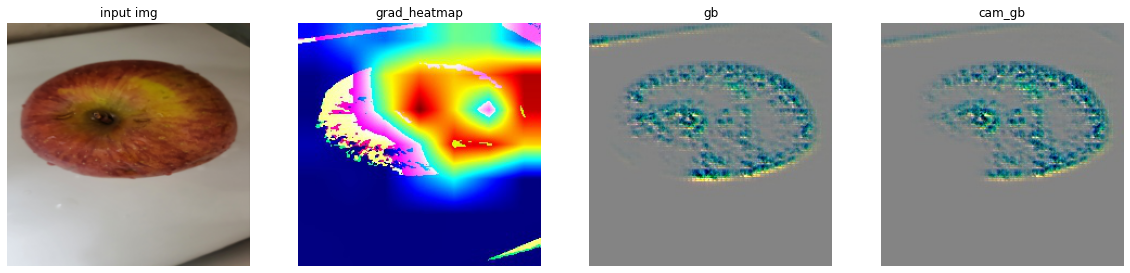

이 사진의 클래스는 apple_bad입니다.


In [59]:
img_show(test_img_path, grad_heatmap_pth, gb_pth, cam_gb_pth)